## First: import necessary modules

In [1]:
#imports

%matplotlib widget

# python core
import os
import datetime as dt
from collections import defaultdict

# python libraries
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# themachinethatgoesping modules
from themachinethatgoesping.echosounders import kongsbergall, simradraw # Filehandlers for kongsbergall and simradraw
from themachinethatgoesping.echosounders import index_functions         # Helper functions for finding echosounder files
from themachinethatgoesping import echosounders
from themachinethatgoesping import pingprocessing 
from themachinethatgoesping import tools as pingtools

In [2]:
# helper functions
close_plots = True
def create_figure(name: str, return_ax: bool = True):
    """Helper function to create a figure with a given name that returns the figure and axis
    """
    if close_plots:
        plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

def set_ax_timeformat(ax, timeformat = "%d-%m-%Y %H:%M:%S"):
    if not hasattr(ax, '__iter__'):
        ax = [ax]
    
    for a in ax:
        a.xaxis.set_major_formatter(mdates.DateFormatter(timeformat))
        a.xaxis.set_major_locator(mdates.AutoDateLocator())
        a.tick_params(axis='x', rotation=30)

# 
def clear_memory():
    import gc
    gc.collect()
    
    import ctypes
    libc = ctypes.CDLL("libc.so.6") # clearing cache 
    libc.malloc_trim(0)

def get_ek80_pings(folders):
    # --- find all files ---
    files   = index_functions.find_files(folders, [".raw"])
    
    # --- init cache paths ---
    cache_paths = index_functions.get_cache_file_paths(files)
    
    # --- Load the data EK80 ---
    fm = simradraw.SimradRawFileHandler(files, file_cache_paths=cache_paths, init = False)
    fm.navigation_interface.set_min_gga_quality(4)
    fm.navigation_interface.init_from_file(file_cache_paths=cache_paths)
    fm.ping_interface.init_from_file(file_cache_paths=cache_paths)
    
    # change heave direction
    for p in tqdm(fm.get_pings(), delay =5):    
        s = p.get_sensor_data_latlon()
        s.heave = -s.heave
        p.set_sensor_data_latlon(s)
    
        c = p.get_sensor_configuration()
        c.set_depth_source("0",0,0,1.4)
        c.set_position_source("0",0,0,0)

    return fm.get_pings()

def get_em2040_pings(folders):
    # --- find all files ---
    files   = index_functions.find_files(folders, [".all", ".wcd"])
    
    # --- init cache paths ---
    cache_paths = index_functions.get_cache_file_paths(files)
    
    # --- Load the data EM2040 ---
    fm = kongsbergall.KongsbergAllFileHandler(files, file_cache_paths=cache_paths, init=False)
    
    # correct transducer offsets by 0.5m
    fm.configuration_interface.init_from_file(file_cache_paths=cache_paths)
    for c in fm.configuration_interface.per_file():
        s = c.read_sensor_configuration()
        for t in s.get_target_ids():
            if "TRX" in t:
                T = s.get_target(t)
                T.z += 0.5
                s.add_target(t, T)
    
        c.set_sensor_configuration(s)
    fm.ping_interface.init_from_file(file_cache_paths=cache_paths)

    return fm.get_pings()

## Open files from a survey

#### Find files (.raw and .all/.wcd)

In [3]:
# define a list of folder(s) to search for raw data files
# notes: 
#   - subdirectories will be searched as well
#   - you can add multiple folders by appending them to the list
#   - pair of files (e.g. .all and .wcd) don't have to be in the same folder
folders = []
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Stations")
folders.append("/home/data/turbeams/TURBEAMS_data_crunshing/campaigns/05_TURBEAMS_April_2023/Transect")


#### Open ek80 data
- here we open the ek80 data using the helper function defined above
- we then imideately filter the pings to only include valid pings from the ES333 transducer


In [4]:
# open files in the specified folders and extract pings
ek80_pings = get_ek80_pings(folders)
print()
print(f'Initial pings: {len(ek80_pings)}')

#select only pings from the required transducer
channel_ids = ek80_pings.find_channel_ids()
for channel_id in channel_ids:
    if 'ES333' in channel_id:
        break
else:
    raise RuntimeError(f"Could not find channel id with 'ES333' in {channel_ids}")
ek80_pings = ek80_pings(channel_id)
print(f'Pings from channel {channel_id}: {len(ek80_pings)}')

ek80_pings = pingprocessing.filter_pings.by_features(ek80_pings, ['watercolumn'])
print(f'Pings with water column feature: {len(ek80_pings)}')

#clear_memory
clear_memory()

Found 659 files
indexing files ⠠ 99% :01s<00m:00s] [Found: 4033171 datagrams in 659 files (56889MB)]                                                 
Initializing SimradRawConfigurationDataInterface from file data ⠁ 100% :00s<00m:00s] [Done]            
Initializing SimradRawNavigationDataInterface from file data ⠐ 100% :00s<00m:00s] [Done]            
Initializing SimradRawPingDataInterface from file data ⠂ 99% :03s<00m:00s] [Done]                                              

Initial pings: 526981
Pings from channel WBT 400058-15 ES333-7C_ES: 105117
Pings with water column feature: 105117


In [5]:
# open files in the specified folders and extract pings
em2040_pings = get_em2040_pings(folders)
print()
print(f'Initial pings: {len(em2040_pings)}')

#select only pings from the required transducer
channel_ids = em2040_pings.find_channel_ids()
if len(channel_ids) != 2:
    raise RuntimeError(f"Len of channel_ids should be 2! {channel_ids}")
    
em2040_trx1_pings = em2040_pings(channel_ids[0])
em2040_trx2_pings = em2040_pings(channel_ids[1])
print(f'Pings from channel {em2040_trx1_pings.find_channel_ids()[0]}: {len(em2040_trx1_pings)}')
print(f'Pings from channel {em2040_trx2_pings.find_channel_ids()[0]}: {len(em2040_trx2_pings)}')

em2040_trx1_pings = pingprocessing.filter_pings.by_features(em2040_trx1_pings, ['watercolumn'])
em2040_trx2_pings = pingprocessing.filter_pings.by_features(em2040_trx2_pings, ['watercolumn'])
print(f'Pings from channel {em2040_trx1_pings[0].get_channel_id()} with watercolumn: {len(em2040_trx1_pings)}')
print(f'Pings from channel {em2040_trx2_pings[0].get_channel_id()} with watercolumn: {len(em2040_trx2_pings)}')

#delete not used pings
del em2040_pings

#clear_memory
clear_memory()

Found 288 files
indexing files ⠁ 99% :01s<00m:00s] [Found: 5130471 datagrams in 288 files (25571MB)]                                                 
Initializing KongsbergAllConfigurationDataInterface from file data ⠄ 100% :00s<00m:00s] [Done]            
Initializing KongsbergAllNavigationDataInterface from file data ⢀ 100% :03s<00m:00s] [Done]            
Initializing KongsbergAllPingDataInterface from file data ⡀ 99% :05s<00m:00s] [Done]                                              

Initial pings: 210675
Pings from channel TRX-2004: 105340
Pings from channel TRX-2031: 105335
Pings from channel TRX-2004 with watercolumn: 105335
Pings from channel TRX-2031 with watercolumn: 105335


## Create echograms of the data

#### define echogram function

In [6]:
class EchoPingParameters:
    def __init__(self, 
                 pings, 
                 max_pings   = 10000, 
                 max_samples = None,
                 max_image_size = 10000 * 3000,
                 min_time = np.nan,
                 max_time = np.nan, 
                 min_depth = np.nan,
                 max_depth = np.nan,
                 min_delta_t = np.nan,
                 min_delta_t_quantile = 0.05,
                 pss = echosounders.pingtools.PingSampleSelector(),
                 linear_mean = True,
                 verbose=True):
        
        echopingtimes, echopingnumbers = self.sample_ping_times(
            pings = pings,
            max_pings = max_pings,
            min_time = min_time,
            max_time = max_time,
            min_delta_t = min_delta_t,
            min_delta_t_quantile = min_delta_t_quantile,
            verbose = verbose)

        if max_samples is None:
            max_samples = int(max_image_size/len(echopingnumbers))
        
        AV = []
        min_r = []
        max_r = []
        res_r = []
        min_d = []
        max_d = []
        bottom_d = []
        nrs = {}
        times = []
        
        nroff=0
        
        for NR,nr in enumerate(tqdm(np.unique(echopingnumbers))):
            if nr == -1:
                nroff += 1
                continue
                
            nrs[nr] = NR - nroff
            
            ping = pings[nr]
            
            sel = pss.apply_selection(ping.watercolumn)
            c = ping.watercolumn.get_sound_speed_at_transducer()
            z = ping.get_geolocation().z
            res_r.append(ping.watercolumn.get_sample_interval()*c*0.5)
            min_r.append(np.max(ping.watercolumn.get_first_sample_offset_per_beam()[sel.get_beam_numbers()])*res_r[-1])
            max_r.append(np.max(ping.watercolumn.get_number_of_samples_per_beam(sel))*res_r[-1] + min_r[-1])
            min_d.append(z + min_r[-1])
            max_d.append(z + max_r[-1])
            times.append(ping.get_timestamp())
        
            if ping.has_bottom():
                sel_bottom = pss.apply_selection(ping.bottom)
                #bd = np.nanmin(p.bottom.get_xyz(sel_bottom).z) + p.get_geolocation().z
                # this is incorrect
                bd = np.nanmin(ping.bottom.get_xyz(sel).z) + ping.get_geolocation().z
        
                bottom_d.append(bd)
            else:
                bottom_d.append(np.nan)
            
            av = ping.watercolumn.get_av(sel)
            if av.shape[0] == 1:
                av = av[0]
            else:
                if linear_mean:
                    av = np.power(10,av*0.1)
        
                av = np.nanmean(av,axis=0)
        
                if linear_mean:
                    av = 10*np.log10(av)
        
            AV.append(av)

        self.AV    = AV
        self.min_d = np.array(min_d)
        self.max_d = np.array(max_d)
        self.res_r = np.array(res_r)
        self.min_r = np.array(min_r)
        self.max_r = np.array(max_r)
        self.bottom_d = np.array(bottom_d)
        self.times=np.array(times)
        self.echopingtimes = np.array(echopingtimes)
        self.echopingtimestep = self.echopingtimes[1] - self.echopingtimes[0]
        self.echopingnumbers = np.array(echopingnumbers)
        self.nrs = nrs
        self.depths = self.sample_image_depths(self.min_d, self.max_d, self.res_r, min_depth, max_depth, max_samples)
        self.ranges = self.sample_image_depths(self.min_r, self.max_r, self.res_r, min_depth, max_depth, max_samples)
        self.range_step = self.depths[1] - self.depths[0]

    @staticmethod
    def sample_ping_times(pings, max_pings=10000, min_time = np.nan, max_time = np.nan, min_delta_t = np.nan, min_delta_t_quantile = 0.05, verbose=True):
        
        min_time = np.nanmax([pings[0].get_timestamp(), min_time])
        max_time = np.nanmin([pings[-1].get_timestamp(), max_time])
        
        if verbose:
            print(f'- Min time  : {dt.datetime.fromtimestamp(min_time,dt.UTC)}\n- Max time  : {dt.datetime.fromtimestamp(max_time,dt.UTC)}\n- Diff {max_time-min_time}')
        
        # filter pings by time range and find delta t per transducer
        pings_filtered = pingprocessing.filter_pings.by_time(pings, min_time, max_time)
        pings_per_channel = pingprocessing.split_pings.by_channel_id(pings_filtered)
        
        ping_delta_t = []
        for cid, P in pings_per_channel.items():
            for i in range(1,len(P)):
                ping_delta_t.append(P[i].get_timestamp() - P[i-1].get_timestamp())
        
        min_delta_t = np.nanmax([np.nanquantile(ping_delta_t,min_delta_t_quantile), min_delta_t])
                
        # get ping_times
        ping_times = np.array([p.get_timestamp() for p in tqdm(pings, delay=2)])
        ping_numbers = np.array(list(range(len(pings))))
        
        echo_times = np.linspace(min_time,max_time,max_pings)
        delta_t = (echo_times[1]-echo_times[0])
        if delta_t < min_delta_t:
            delta_t = min_delta_t
            echo_times = np.arange(min_time, max_time + delta_t, delta_t)
        
        
        # get nearest neighbor for echo_times
        interplator = pingtools.vectorinterpolators.NearestInterpolator(ping_times,ping_numbers)
        echopingnumbers = np.array(interplator(echo_times)).astype(int)
        echopingtimes = ping_times[echopingnumbers]
        
        # exclude all times where the time difference is larger than delta_t/2
        echopingdiffs = np.abs(echo_times - echopingtimes)
        excl = np.argwhere(echopingdiffs > delta_t * 0.5)
        
        echopingtimes[excl]   = np.nan
        echopingnumbers[excl] = -1
        
        # remove duplicate numbers
        u, c = np.unique(echopingnumbers, return_counts=True)
        C = int(np.quantile(c,0.75,method='linear'))
    
        if C > 1:
            max_pings = int(max_pings/C)
    
            if max_pings > 10:
                print("MAX PINGS:", max_pings, C)
                return EchoPingParameters.sample_ping_times(
                      pings = pings,
                      max_pings = max_pings,
                      min_time = min_time,
                      max_time = max_time,
                      verbose = verbose)
    
        return echo_times, echopingnumbers

    @staticmethod
    def sample_image_depths(min_d, max_d, res_r, min_depth, max_depth, max_samples = 5000):
        # filter 
        if min_depth is None: min_depth = np.nanquantile(min_d,0.25)/1.5        
        if max_depth is None: max_depth = np.nanquantile(max_d,0.75)*1.5
        min_resolution = np.nanquantile(res_r,0.25)/1.5
                
        res = np.nanmax([np.nanmin(res_r), min_resolution])
        mind = np.nanmax([np.nanmin(min_d), min_depth])
        maxd = np.nanmin([np.nanmax(max_d), max_depth])
        
        depths = np.arange(mind, maxd + res, res)
        
        if len(depths) > max_samples:
            depths = np.linspace(mind, maxd, max_samples)
        
        return depths

    def build_image(self, use_range = False, use_datetime = True):
        
        i_echo = []
        i_av   = []

        if use_range:
            min_d = self.min_r
            max_d = self.max_r
            depths = self.ranges
        else:
            min_d = self.min_d
            max_d = self.max_d
            depths = self.depths

        image = np.empty((len(self.echopingnumbers),len(depths)))
        image.fill(np.nan)
        
        for i in tqdm(range(len(self.AV))):
            interpolator = pingtools.vectorinterpolators.LinearInterpolator([min_d[i],max_d[i]],[0,len(self.AV[i])])
            index_av = np.round(interpolator(depths)).astype(int)
            index_echo = np.array(range(len(depths)))
        
            index_echo = index_echo[index_av >= 0]
            index_av = index_av[index_av >= 0]
            
            i_echo.append(index_echo[index_av < len(self.AV[i])])
            i_av.append(index_av[index_av < len(self.AV[i])])
        
        for i,nr in enumerate(tqdm(self.echopingnumbers)):
            if nr == -1:
                continue
            NR = self.nrs[nr]
            
            index_echo = i_echo[NR]
            index_av = i_av[NR]
            image[i][index_echo] = self.AV[NR][index_av]

        extent = [
            self.echopingtimes[0]  - self.echopingtimestep*0.5,
            self.echopingtimes[-1] + self.echopingtimestep*0.5,
            depths[-1] + self.range_step*0.5,
            depths[0]  - self.range_step*0.5
        ]

        if use_datetime:
            extent[0] = dt.datetime.fromtimestamp(extent[0], dt.UTC)
            extent[1] = dt.datetime.fromtimestamp(extent[1], dt.UTC)
        
        return image, extent
        

In [7]:

class EchogramBuilder:
    def __init__(self, pings, pingsampleselector = echosounders.pingtools.PingSampleSelector()):
        self.pings = np.array(pings)
        self.pss = pingsampleselector

    def build_echogram(
        self,
        max_pings   = 10000, 
        max_samples = None,
        max_image_size = 10000 * 3000,
        min_time = np.nan,
        max_time = np.nan, 
        min_depth = np.nan,
        max_depth = np.nan,
        min_delta_t = np.nan,
        min_delta_t_quantile = 0.05,
        pss = None,
        linear_mean = True,
        use_range = False,
        verbose=True
        ):

        if pss is None:
            pss = self.pss
        
        # build echogram parameters
        echoparam = EchoPingParameters( 
            pings = self.pings, 
            max_pings   = max_pings,
            max_samples = max_samples,
            max_image_size = max_image_size,
            min_time = min_time,
            max_time = max_time, 
            min_depth = min_depth,
            max_depth = max_depth,
            pss = pss,
            linear_mean = linear_mean,
            verbose=verbose)
        self.last_echoparam = echoparam
        
        image, extent = echoparam.build_image(use_datetime = True, use_range = use_range)
        echo = pingprocessing.watercolumn.echograms.EchogramSection(image)
        
        bottom_depth = echoparam.bottom_d
        if use_range:
            heave = echoparam.min_d - echoparam.min_r
            bottom_depth -= heave

        echo.set_bottom_depths(bottom_depth[np.isfinite(bottom_depth)], echoparam.times[np.isfinite(bottom_depth)])

        echo.set_echosounder_depths(echoparam.min_d[np.isfinite(echoparam.min_d)], echoparam.times[np.isfinite(echoparam.min_d)])
        echo.set_ping_times(echoparam.echopingtimes)

        if use_range:
            echo.set_sample_depths(echoparam.ranges)
        else:
            echo.set_sample_depths(echoparam.depths)
        #echo.set_ping_distances
        #echo.set_ping_numbers
        #echo.set_sample_numbers

        return echo

In [8]:
def plot_echogram(self, 
                  ping_axis = 'time', 
                  sample_axis = 'depth',
                  ax = None,
                  fig_size = (15,4),
                  name = 'Echogram',
                  colorbar = True,
                  plot_bottom = True,
                  **kwargs):
    
    image,extent = self.get_echogram(ping_axis=ping_axis, sample_axis=sample_axis)
    
    plot_args = {
    "vmin" : np.nanquantile(image, 0.05),
    "vmax" : np.nanquantile(image, 0.95),
    "aspect" : "auto",
    "cmap" : "YlGnBu_r"
    }
    plot_args.update(kwargs)

    if ax is None:
        fig,ax = create_figure(name)
        fig.set_size_inches(15,4)
        set_ax_timeformat(ax)
        
    mapable = ax.imshow(image.transpose(), extent = extent, **plot_args)

    if plot_bottom and len(echo_z._bottom_depths) > 0:
        times = self.get_ping_times_unixtimes()
        bottom = self.bottom_depth_per_ping_time(times)
        ax.plot(self.get_ping_times_datetimes(), bottom, color='black')

    if colorbar:
        ax.get_figure().colorbar(mapable,ax=ax)

    return ax.get_figure(),ax

In [9]:
pss = echosounders.pingtools.PingSampleSelector()
pss.select_beam_range_by_angles(-3.5, 3.5)

In [10]:
eb_ek80 = EchogramBuilder(ek80_pings)
eb_em2040_1 = EchogramBuilder(em2040_trx1_pings, pingsampleselector = pss)
eb_em2040_2 = EchogramBuilder(em2040_trx2_pings, pingsampleselector = pss)

- Min time  : 2023-04-19 18:37:18.366000+00:00
- Max time  : 2023-04-22 02:31:09.869000+00:00
- Diff 201231.50300002098


  0%|          | 0/6351 [00:00<?, ?it/s]

  0%|          | 0/6350 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

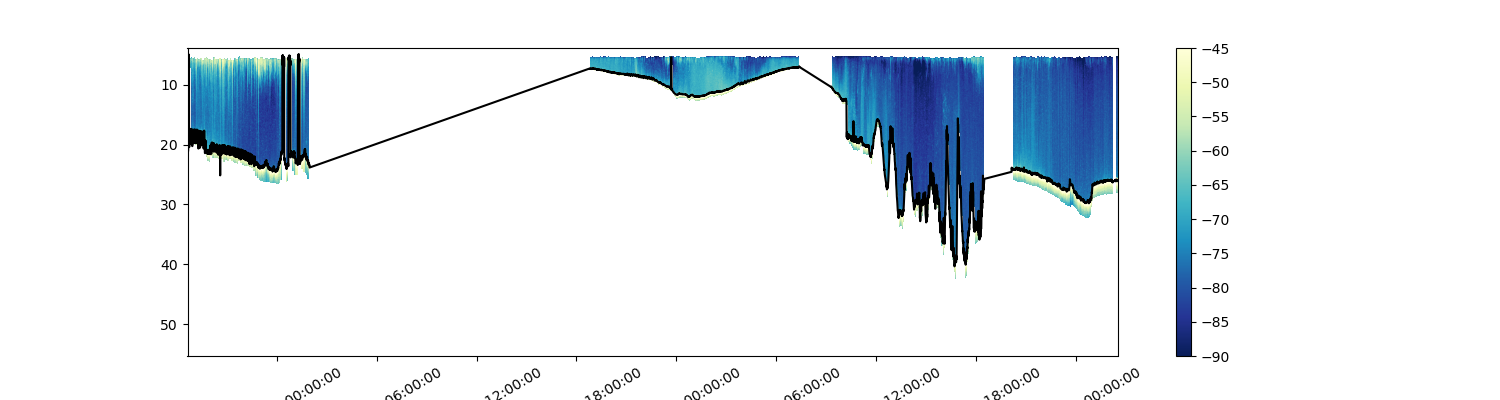

In [44]:
echo_z = eb_em2040_1.build_echogram(
    max_pings   = 10000,
    #max_samples = 30000,
    max_image_size = 10000 * 3000,
    min_time = np.nan,
    max_time = np.nan, 
    min_depth = np.nan,
    max_depth = np.nan,
    linear_mean = True,
    use_range=False,
    verbose=True)

vmin = -90
vmax = -45
fig_z,ax_z = plot_echogram(echo_z, name="full echogram", vmin=vmin, vmax = vmax)

In [45]:
min_time_, max_time_ = mdates.num2date(ax_z.get_xlim())
ylim = ax_z.get_ylim()

echo_zz = eb_em2040_1.build_echogram(
    max_pings   = 10000,
    #max_samples = 30000,
    max_image_size = 10000 * 3000,
    min_time = min_time_.timestamp(),
    max_time = max_time_.timestamp(), 
    min_depth = np.nan,
    max_depth = np.nan,
    linear_mean = True,
    use_range=False,
    verbose=True)

bottom_times = echo_z.get_ping_times_unixtimes()
bottom_dephts = echo_z.bottom_depth_per_ping_time(bottom_times)

plot_echogram(echo_zz, name="full echogram", ax = ax_z, colorbar=False, vmin=vmin, vmax=vmax)
ax_z.set_xlim(min_time_,max_time_)
ax_z.set_ylim(ylim)

- Min time  : 2023-04-21 16:01:56.096524+00:00
- Max time  : 2023-04-21 16:04:54.180208+00:00
- Diff 178.08368396759033


  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

  0%|          | 0/149 [00:00<?, ?it/s]

(40.912200367424106, 4.261178481877025)

In [16]:
depth_limits = [
    (6,8),
    (8,10),
    (10,12),
    (12,14),
    (14,16),
    (16,18),
    (18,20),
    (20,22),
    (22,24),
    (24,26),

]

# depth_limits = [
#     (6,9),
#     (9,10),
#     (10,11),
#     (11,12),
#     (12,13),
#     (13,14),
#     (14,15),
#     (15,16),
#     (16,17),
#     (17,18),
#     (18,19),
#     (19,20),
# ]

depth_limits = [
    (10,20),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,10),
    (10,11),
    (11,12),
    (12,13),
    (13,14),
    (14,15),
    (15,16),
    (16,17),
    (17,18),
    (18,19),
    (19,20),
    (20,22),
    (22,24),
    (24,26),
    (26,28),
    (28,30),
    (30,33),
    (33,36),
    (36,40),
]


def get_depth_layer(echo, depth_limit):
    global bottom,times, lower, upper
    times = echo.get_ping_times_unixtimes()
    bottom = echo.bottom_depth_per_ping_time(times) -1.5
    lower = np.array([depth_limit[1] for _ in times]).astype(float)
    upper = np.array([depth_limit[0] for _ in times]).astype(float)

    for i,(l,u,b) in enumerate(zip(lower,upper,bottom)):
        # if u > b: 
        #     lower[i] = u
        if l > b:
            lower[i] = b
        if lower[i] < u:
            lower[i] = u

    image,extent =  echo.get_echogram_layer(lower_depth=lower, upper_depth=upper, ping_axis='time', sample_axis='depth')
    image[upper >= lower,:] = np.nan
    return image, extent
    

2023-04-21 08:46:27.949262+00:00
2023-04-22 02:31:01.897275+00:00
4.656989209912496 43.35164099889602


  0%|          | 0/8713 [00:00<?, ?it/s]

  0%|          | 0/8712 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 208) [19468.365564300508, 19469.1049200344, 20.020093520076255, 9.979592555937714]
(10000, 22) [19468.365564300508, 19469.1049200344, 6.014064887397926, 4.9954633403114075]
(10000, 21) [19468.365564300508, 19469.1049200344, 6.982920214228124, 6.012823502717153]
(10000, 22) [19468.365564300508, 19469.1049200344, 8.00028037663387, 6.981678829547351]
(10000, 22) [19468.365564300508, 19469.1049200344, 9.017610261364476, 7.999008714277957]
(10000, 21) [19468.365564300508, 19469.1049200344, 9.986465588194672, 9.016368876683703]
(10000, 22) [19468.365564300508, 19469.1049200344, 11.00382575060042, 9.9852242035139]
(10000, 22) [19468.365564300508, 19469.1049200344, 12.021155635331025, 11.002554088244505]
(10000, 21) [19468.365564300508, 19469.1049200344, 12.990010962161222, 12.019914250650253]
(10000, 22) [19468.365564300508, 19469.1049200344, 14.00737112456697, 12.988769577480449]
(10000, 22) [19468.365564300508, 19469.1049200344, 15.024701009297575, 14.006099462211054]
(10000, 21) [1

  0%|          | 0/8713 [00:00<?, ?it/s]

  0%|          | 0/8712 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 208) [19468.365564300508, 19469.1049200344, 20.020093520076255, 9.979592555937714]
(10000, 22) [19468.365564300508, 19469.1049200344, 6.014064887397926, 4.9954633403114075]
(10000, 21) [19468.365564300508, 19469.1049200344, 6.982920214228124, 6.012823502717153]
(10000, 22) [19468.365564300508, 19469.1049200344, 8.00028037663387, 6.981678829547351]
(10000, 22) [19468.365564300508, 19469.1049200344, 9.017610261364476, 7.999008714277957]
(10000, 21) [19468.365564300508, 19469.1049200344, 9.986465588194672, 9.016368876683703]
(10000, 22) [19468.365564300508, 19469.1049200344, 11.00382575060042, 9.9852242035139]
(10000, 22) [19468.365564300508, 19469.1049200344, 12.021155635331025, 11.002554088244505]
(10000, 21) [19468.365564300508, 19469.1049200344, 12.990010962161222, 12.019914250650253]
(10000, 22) [19468.365564300508, 19469.1049200344, 14.00737112456697, 12.988769577480449]
(10000, 22) [19468.365564300508, 19469.1049200344, 15.024701009297575, 14.006099462211054]
(10000, 21) [1

  0%|          | 0/8721 [00:00<?, ?it/s]

  0%|          | 0/8720 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(10000, 1685) [19468.365564300508, 19469.1049200344, 20.000927449689986, 10.000205941341688]
(10000, 169) [19468.365564300508, 19469.1049200344, 5.998999435773965, 5.001302753230905]
(10000, 170) [19468.365564300508, 19469.1049200344, 7.002481289120401, 5.998845935847917]
(10000, 169) [19468.365564300508, 19469.1049200344, 8.000024471737413, 7.002327789194353]
(10000, 169) [19468.365564300508, 19469.1049200344, 8.99756810984382, 7.99987142730076]
(10000, 170) [19468.365564300508, 19469.1049200344, 10.001049963190255, 8.997414609917772]
(10000, 169) [19468.365564300508, 19469.1049200344, 10.998593145807268, 10.000896463264207]
(10000, 170) [19468.365564300508, 19469.1049200344, 12.002074999153702, 10.99843964588122]
(10000, 169) [19468.365564300508, 19469.1049200344, 12.999618181770716, 12.001921499227654]
(10000, 169) [19468.365564300508, 19469.1049200344, 13.997161819877123, 12.999465137334061]
(10000, 170) [19468.365564300508, 19469.1049200344, 15.000643673223557, 13.997008319951075]

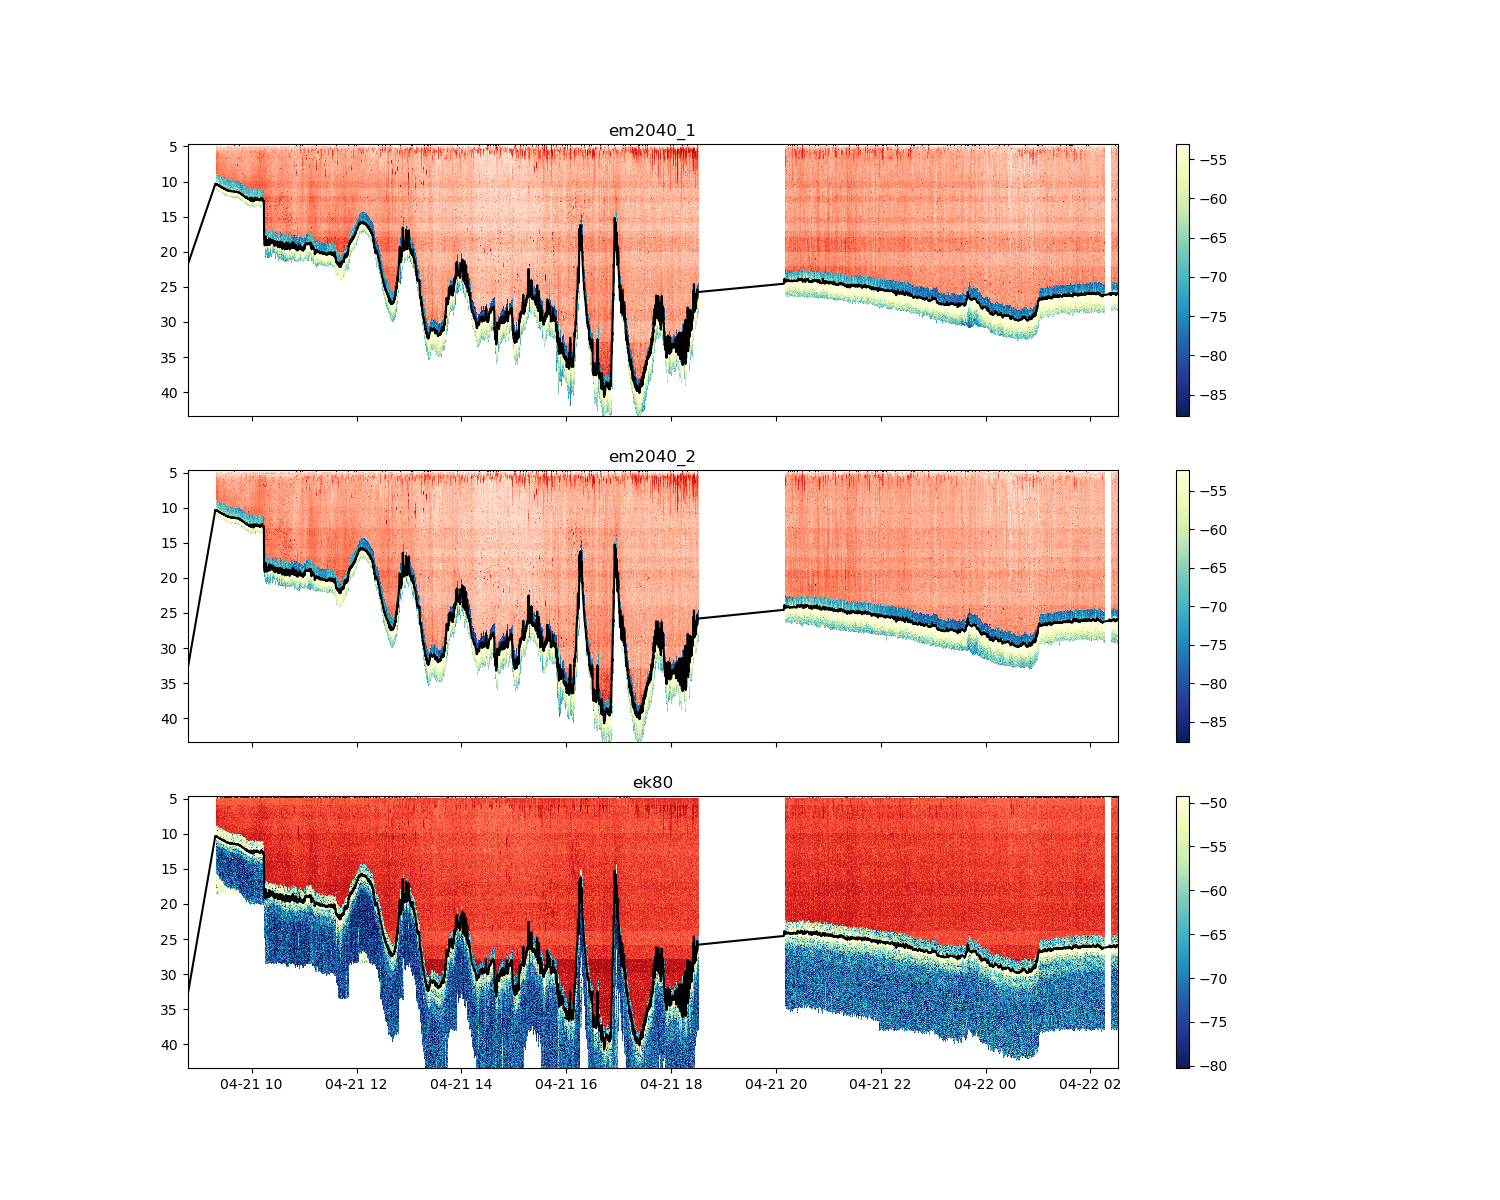

In [17]:
min_time_, max_time_ = mdates.num2date(ax_z.get_xlim())
print(min_time_)
print(max_time_)

max_depth_, min_depth_ = ax_z.get_ylim()
print(min_depth_, max_depth_)

fig = create_figure("compare", return_ax = False)
fig.set_size_inches(15,4*3)
ax1,ax2,ax3 = fig.subplots(nrows=3,sharex=True, sharey=True)

limit_layers = defaultdict(dict)

for eb,ax_,name in zip([eb_em2040_1, eb_em2040_2, eb_ek80 ],[ax1,ax2,ax3],["em2040_1","em2040_2","ek80"]):
    echo_zz = eb.build_echogram(
        max_pings   = 10000,
        max_samples = 30000,
        #max_image_size = 30000 * 3000,
        min_time = min_time_.timestamp(),
        max_time = max_time_.timestamp(), 
        min_depth = min_depth_,
        max_depth = max_depth_,
        linear_mean = True,
        use_range=False,
        verbose=False)

    if len(echo_zz._bottom_depths) == 0:
        echo_zz.set_bottom_depths(bottom_depths, bottom_times)
    else:
        bottom_times = echo_zz.get_ping_times_unixtimes()
        bottom_depths = echo_zz.bottom_depth_per_ping_time(bottom_times)
    
    fig_zz,ax_zz = plot_echogram(echo_zz, name="echogram zz", ax = ax_, interpolation = "nearest")

    for depth_limit in depth_limits:
        image,extent = get_depth_layer(echo_zz, depth_limit)
        ax_.imshow(image.transpose(), extent = extent, aspect = "auto", cmap = "Reds", interpolation = "nearest")

        limit_layers[f'{depth_limit[0]}-{depth_limit[1]}'][name] = (image, echo_zz.get_ping_times_datetimes())

        print(image.shape, extent)
    ax_.set_title(name)
    ax_.set_xlim(min_time_, max_time_)
    ax_.set_ylim(max_depth_, min_depth_)

In [18]:
import pandas as pd
datas = {}


for depth_limit, layer in tqdm(limit_layers.items()):
    data = []
    for trx, (image, times) in layer.items():
        df = pd.DataFrame()
        df["time"] = times
        df[f"{trx}"] = np.nanmean(image,axis=1)
        df.set_index('time', inplace=True)
        df = df.resample('5Min').apply(np.nanmedian)

        if trx == 'ek80':
           df[f'{trx}'] =df[f'{trx}'] + np.mean(np.array(depth_limit.split('-')).astype(float))*2*0.07361

        data.append(df)

    datas[depth_limit] = pd.concat(data, axis=1)

    


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

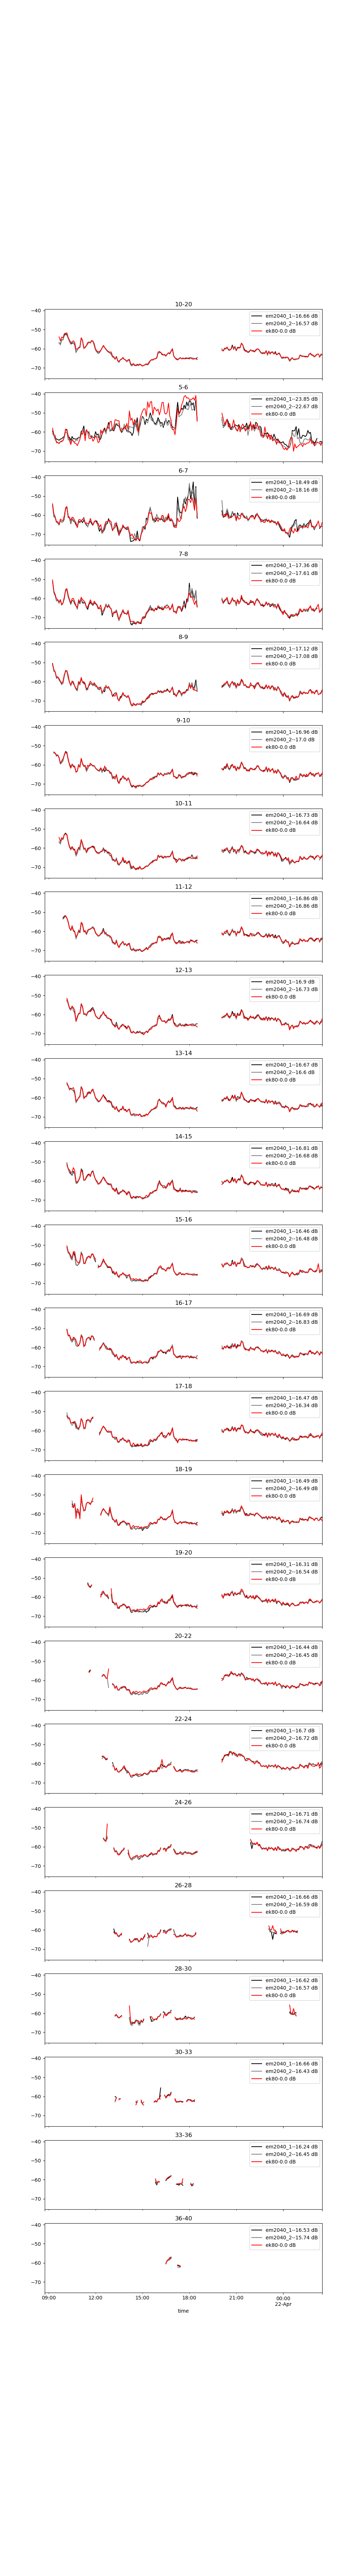

In [19]:
fig = create_figure('layers', return_ax=False)
axes = fig.subplots(nrows=len(datas), sharex=True, sharey=True)
axit = iter(axes)
fig.set_size_inches(10,3*len(axes))

for depth_limit, df in tqdm(datas.items()):
    ax = next(axit)
    ax.set_title(f"{depth_limit}")
    ref0 = np.nanmedian(df['ek80'])
    for trx,color in zip(['em2040_1','em2040_2','ek80'],['black', 'grey', 'red']):
        ref = np.nanmedian(df[trx]) - ref0
        ref_trx = f'{trx}-{round(ref,2)} dB'
        df[ref_trx] = df[trx] - ref
        df.plot(y=ref_trx, ax=ax, label=ref_trx, color = color)

ax.legend()

In [42]:
datas['10-20']diffs

em2040_1   em2040_2       ek80  \
time                                                         
2023-04-21 08:45:00+00:00        NaN        NaN        NaN   
2023-04-21 08:50:00+00:00        NaN        NaN        NaN   
2023-04-21 08:55:00+00:00        NaN        NaN        NaN   
2023-04-21 09:00:00+00:00        NaN        NaN        NaN   
2023-04-21 09:05:00+00:00        NaN        NaN        NaN   
...                              ...        ...        ...   
2023-04-22 02:10:00+00:00 -79.564384 -79.752758 -62.991902   
2023-04-22 02:15:00+00:00        NaN        NaN -62.693241   
2023-04-22 02:20:00+00:00 -81.084789 -80.912817 -64.217542   
2023-04-22 02:25:00+00:00 -79.496708 -79.548240 -63.457293   
2023-04-22 02:30:00+00:00 -79.762074 -79.722145 -62.955011   

                           em2040_1--16.66 dB  em2040_2--16.57 dB  ek80-0.0 dB  
time                                                                            
2023-04-21 08:45:00+00:00                 NaN                 NaN          NaN  
2023-04-21 08:50:00+00:00                 NaN                 NaN          NaN  
2023-04-21 08:55:00+00:00                 NaN                 NaN          NaN  
2023-04-21 09:00:00+00:00                 NaN                 NaN          NaN  
2023-04-21 09:05:00+00:00                 NaN                 NaN          NaN  
...                                       ...                 ...          ...  
2023-04-22 02:10:00+00:00          -62.906591          -63.179306   -62.991902  
2023-04-22 02:15:00+00:00                 NaN                 NaN   -62.693241  
2023-04-22 02:20:00+00:00          -64.426996          -64.339365   -64.217542  
2023-04-22 02:25:00+00:00          -62.838915          -62.974788   -63.457293  
2023-04-22 02:30:00+00:00          -63.104281          -63.148693   -62.955011  

[214 rows x 6 columns]

In [47]:
diffs['em2040_1'][0]

time
2023-04-21 08:45:00+00:00          NaN
2023-04-21 08:50:00+00:00          NaN
2023-04-21 08:55:00+00:00          NaN
2023-04-21 09:00:00+00:00          NaN
2023-04-21 09:05:00+00:00          NaN
                               ...    
2023-04-22 02:10:00+00:00   -62.906591
2023-04-22 02:15:00+00:00          NaN
2023-04-22 02:20:00+00:00   -64.426996
2023-04-22 02:25:00+00:00   -62.838915
2023-04-22 02:30:00+00:00   -63.104281
Freq: 5min, Name: em2040_1, Length: 214, dtype: float64

In [66]:
z = []
for p in tqdm(em2040_trx1_pings):
    z.append(p.get_geolocation().z)

print(np.nanmean(z))

  0%|          | 0/105335 [00:00<?, ?it/s]

5.009144261477822


In [61]:
em2040_trx1_pings[10000].get_geolocation().z

4.728127479553223

  0%|          | 0/24 [00:00<?, ?it/s]

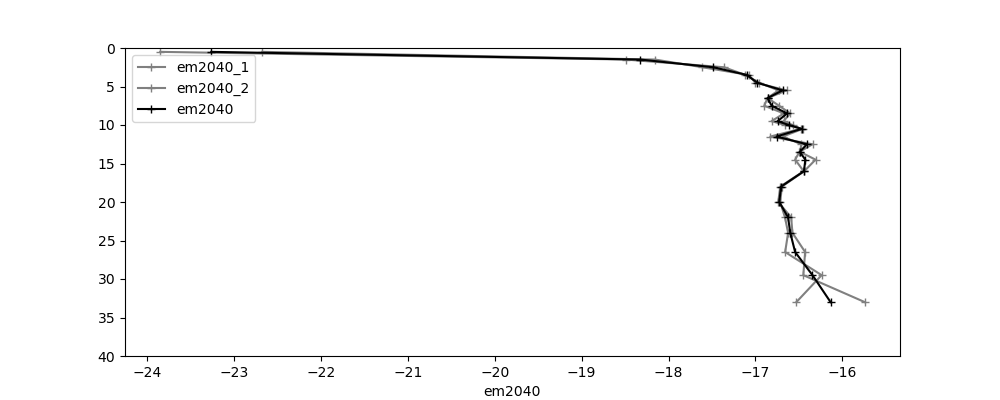

In [70]:
fig = create_figure('layer', return_ax=False)
ax = fig.subplots()
fig.set_size_inches(10,4)

depths = []
diffs = defaultdict(list)
for depth_limit, df in tqdm(datas.items()):
    depths.append(np.mean(np.array(depth_limit.split('-')).astype(float)))
    ref0 = np.nanmedian(df['ek80'])
    for trx,color in zip(['em2040_1','em2040_2','ek80'],['black', 'grey', 'red']):
        ref = np.nanmedian(df[trx]) - ref0
        diffs[trx].append(ref)

depth_data = pd.DataFrame()
depth_data['depth'] = depths
depth_data['range'] = np.array(depths) - 5
for k,v in diffs.items():
    depth_data[k] = v

depth_data['em2040'] = depth_data['em2040_1']
depth_data['em2040'] += depth_data['em2040_2']
depth_data['em2040'] = depth_data['em2040']/2

#depth_data.set_index('depth',inplace=True)
depth_data.sort_values('range', inplace = True)
depth_data.plot(x='em2040_1',y='range',marker='+', color = 'grey',ax=ax, label='em2040_1')
depth_data.plot(x='em2040_2',y='range',marker='+', color = 'grey',ax=ax, label='em2040_2')
depth_data.plot(x='em2040',y='range',marker='+', color = 'black',ax=ax, label='em2040')
ax.set_ylim(40,0)
ax.legend()

In [74]:
depth_data.to_hdf('depth_offsets.hd5','depth')

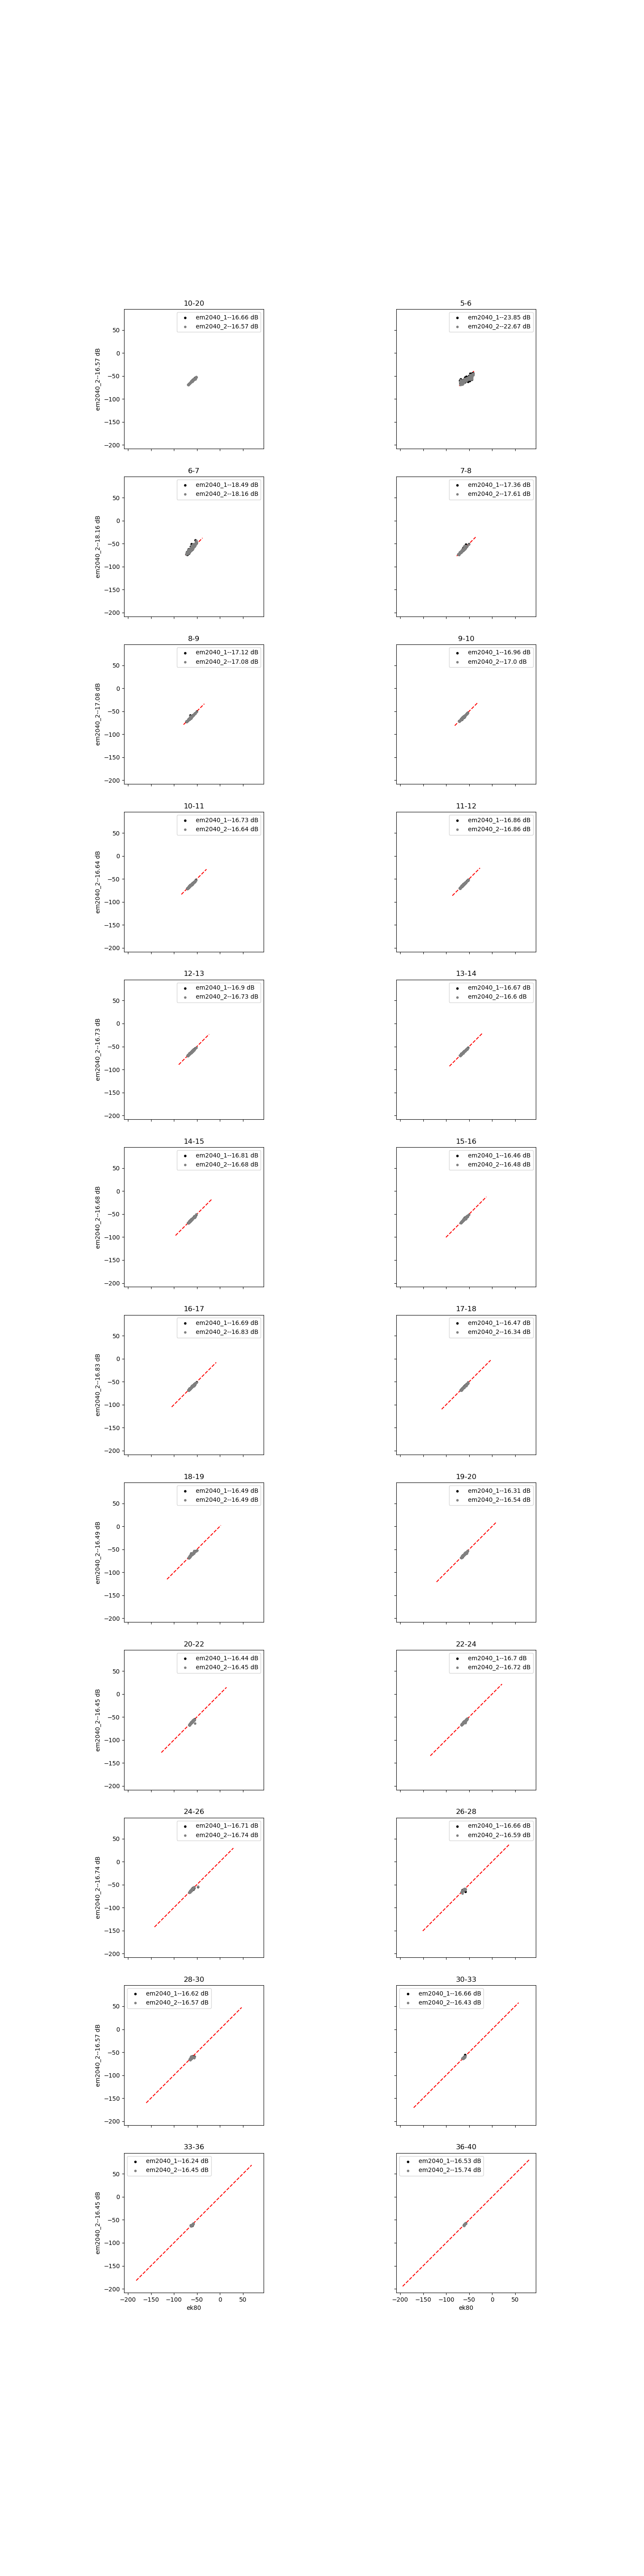

In [75]:
num_figures = len(datas)
nx = int(np.sqrt(num_figures))
nx = 2
ny = int(np.ceil(num_figures/nx))

fig = create_figure('cross-plots', return_ax=False)
axes = fig.subplots(nrows=ny, ncols=nx, sharex=True, sharey=True)
axit = iter(axes.flatten())
fig.set_size_inches(15,5*ny)

for depth_limit, df in datas.items():
    ax = next(axit)
    ax.set_aspect('equal')
    ax.set_title(f"{depth_limit}")
    ax.set_xlabel('ek80')
    ax.set_ylabel('em2040')
    
    ref0 = np.nanmedian(df['ek80'])
    for trx,color in zip(['em2040_1','em2040_2'],['black', 'grey']):
        ref = np.nanmedian(df[trx]) - ref0
        #ref = -15.3
        ref_trx = f'{trx}-{round(ref,2)} dB'
        df[ref_trx] = df[trx] - ref

        df.plot.scatter(x='ek80', y=ref_trx, ax=ax, label=ref_trx, color = color, s=10,zorder = 10)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    ax.plot([min(xlim),max(xlim)],[min(xlim),max(xlim)], color='red', zorder = 0, linestyle='--')    

ax.legend()

In [21]:
from math import pi,sin,radians
c = 1470.
def lam(f):
    return c / f

def k(f):
    return 2*pi/lam(f)

def d(f,a):
    return 3.2/(k(f) * sin(radians(a/2)))

def r1(f,a):
    return (pi * (d(f,a)**2))/(4*lam(f))
def r2(f,a):
    return (d(f,a)**2)/(lam(f))

r1(350000,1), r2(350000,1)
3*r1(350000,1), 2*r2(350000,1)

(33.70675365754998, 28.611181120959483)